In [1]:
import os
from elasticsearch import Elasticsearch, helpers
import pandas as pd

ES_URL = os.getenv("ELASTIC_URL")
ES_USERNAME = os.getenv("ELASTIC_USERNAME")
ES_PASSWORD = os.getenv("ELASTIC_PASSWORD")
CA_CERT_PATH = os.getenv("CA_CERT_PATH")

es = Elasticsearch(
    ES_URL,
    basic_auth=(ES_USERNAME, ES_PASSWORD),
    verify_certs=True,
    ca_certs=CA_CERT_PATH,
)

es.info()


ObjectApiResponse({'name': '2b95d328a763', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'w01tNBhuRNm4R-Z6DKBCGg', 'version': {'number': '9.2.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '25d88452371273dd27356c98598287b669a03eae', 'build_date': '2025-10-21T10:06:21.288851013Z', 'build_snapshot': False, 'lucene_version': '10.3.1', 'minimum_wire_compatibility_version': '8.19.0', 'minimum_index_compatibility_version': '8.0.0'}, 'tagline': 'You Know, for Search'})

In [2]:
INDEX = "reviews"
SOURCE_FIELDS = ["company_name","headline","review","rating","review_date_absolute","source"]

docs = []
for hit in helpers.scan(
    es,
    index=INDEX,
    query={"query": {"match_all": {}}, "_source": SOURCE_FIELDS},
    size=2000,
):
    src = hit["_source"]
    docs.append(src)

len(docs)


60440

In [5]:
import os
import json

# Chemin du snapshot
snapshot_dir = "/app/ml/data/snapshot"
os.makedirs(snapshot_dir, exist_ok=True)

snapshot_path = f"{snapshot_dir}/reviews_snapshot.jsonl"

# Sauvegarde en JSONL (un document par ligne)
with open(snapshot_path, "w", encoding="utf-8") as f:
    for doc in docs:
        f.write(json.dumps(doc, ensure_ascii=False) + "\n")

print("Snapshot sauvegardé :", snapshot_path)
print("Nombre de documents :", len(docs))


Snapshot sauvegardé : /app/ml/data/snapshot/reviews_snapshot.jsonl
Nombre de documents : 60440


In [7]:
import json

snapshot_path = "/app/ml/data/snapshot/reviews_snapshot.jsonl"

loaded_docs = []
with open(snapshot_path, "r", encoding="utf-8") as f:
    for line in f:
        loaded_docs.append(json.loads(line))

print("Snapshot chargé avec succès")
print("Nombre de reviews :", len(loaded_docs))



Snapshot chargé avec succès
Nombre de reviews : 60440


In [8]:
import pandas as pd
import numpy as np

df = pd.DataFrame(loaded_docs)

def to_text(row):
    h = row.get("headline") or ""
    r = row.get("review") or ""
    return (h + " " + r).strip()

df["text"] = df.apply(to_text, axis=1)

def rating_to_sentiment(r):
    try:
        r = float(r)
    except:
        return np.nan
    if r <= 2:  return "negatif"
    if r == 3:  return "neutral"
    return "positif"

df["sentiment"] = df["rating"].apply(rating_to_sentiment)

df = df[(df["text"].str.len() > 0) & df["sentiment"].notna()]
df.head()


,company_name,headline,review,review_date_absolute,rating,source,text,sentiment
0,AliExpress,Excellent achat,Livraison rapide.,2025-01-17,5,trustpilot,Excellent achat Livraison rapide.,positif
1,AliExpress,Peut mieux faire,Expérience moyenne.,2025-06-05,3,trustpilot,Peut mieux faire Expérience moyenne.,neutral
2,AliExpress,Support inutilisable,Très mauvaise expérience.,2025-06-21,1,trustpilot,Support inutilisable Très mauvaise expérience.,negatif
3,AliExpress,Bon rapport qualité/prix,Très satisfait de ma commande. Le produit est ...,2022-02-18,5,trustpilot,Bon rapport qualité/prix Très satisfait de ma ...,positif
4,AliExpress,Litige impossible,Produit jamais reçu.,2021-10-12,1,trustpilot,Litige impossible Produit jamais reçu.,negatif


In [9]:
df["company_name"] = df["company_name"].replace(r"(?i)^justfly$", "justFly", regex=True)
print("Taille du dataset :", df.shape)
print("\nRépartition sentiments :\n", df["sentiment"].value_counts())
print("\nRépartition entreprises :\n", df["company_name"].value_counts())

df["text_len"] = df["text"].str.split().str.len()
print("\nLongueur du texte :\n", df["text_len"].describe())


Taille du dataset : (60440, 8)

Répartition sentiments :
 sentiment
negatif    32762
positif    22152
neutral     5526
Name: count, dtype: int64

Répartition entreprises :
 company_name
Showroomprive    10200
Amazon           10040
Apple            10040
justFly          10040
AliExpress       10000
Facebook         10000
Aliexpress          40
Westernunion        40
Loaded              40
Name: count, dtype: int64

Longueur du texte :
 count    60440.000000
mean         9.046525
std          8.769678
min          1.000000
25%          5.000000
50%          7.000000
75%         13.000000
max        637.000000
Name: text_len, dtype: float64


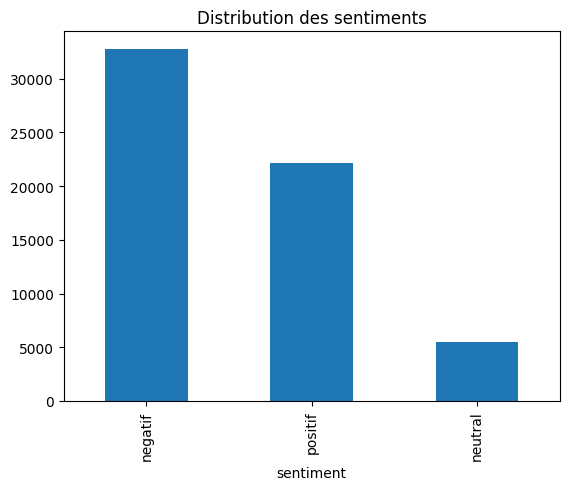

In [11]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="bar", title="Distribution des sentiments")
plt.show()



In [12]:
import spacy
nlp = spacy.load("fr_core_news_md")


In [13]:
# Extraire automatiquement toutes les entreprises du dataset
all_companies = (
    df["company_name"]
    .dropna()
    .astype(str)
    .str.lower()
    .unique()
)

print("Entreprises détectées :", all_companies)


Entreprises détectées : ['aliexpress' 'showroomprive' 'apple' 'amazon' 'justfly' 'westernunion'
 'loaded' 'facebook']


In [14]:
from spacy.lang.fr.stop_words import STOP_WORDS

# Stopwords français standard
stopwords = set(STOP_WORDS)

# Ajouter dynamiquement les noms d'entreprises détectés
for c in all_companies:
    stopwords.add(c.lower())

# Extraire aussi les tokens contenus dans les noms d'entreprises
company_tokens = set()

for name in all_companies:
    for token in name.split():
        company_tokens.add(token.lower())

stopwords.update(company_tokens)

print("Nombre total de stopwords :", len(stopwords))


Nombre total de stopwords : 515


In [15]:
import re

def clean_advanced(text):
    # lowercase
    text = text.lower()
    
    # enlever caractères spéciaux
    text = re.sub(r"[^a-zA-Z0-9À-ÿ ]", " ", text)
    text = re.sub(r"\s+", " ", text)

    doc = nlp(text)
    cleaned_tokens = []

    for token in doc:
        lemma = token.lemma_.strip()

        # filtres
        if len(lemma) < 3:
            continue
        if lemma in stopwords:
            continue

        cleaned_tokens.append(lemma)

    return " ".join(cleaned_tokens)


In [16]:
df["text_cleaned"] = df["text"].apply(clean_advanced)
df[["text", "text_cleaned"]].head(10)


,text,text_cleaned
0,Excellent achat Livraison rapide.,excellent achat livraison rapide
1,Peut mieux faire Expérience moyenne.,pouvoir mieux faire expérience moyen
2,Support inutilisable Très mauvaise expérience.,support inutilisable mauvais expérience
3,Bon rapport qualité/prix Très satisfait de ma ...,bon rapport qualité prix satisfait commande pr...
4,Litige impossible Produit jamais reçu.,litige impossible produit jamais recevoir
5,Litige impossible Très mauvaise expérience. Pr...,litige impossible mauvais expérience produit j...
6,Prix imbattables Très satisfait de ma commande...,prix imbattable satisfait commande produit con...
7,Très mauvaise expérience Contrefaçon.,mauvais expérience contrefaçon
8,Livraison très lente Décevant.,livraison lent décevant
9,Arnaque du vendeur Remboursement refusé malgré...,arnaqu vendeur remboursement refuser demande d...


In [18]:
output_dir = "/app/ml/data/cleaned"
output_path = f"{output_dir}/reviews_cleaned.jsonl"

df[["text_cleaned", "sentiment"]].to_json(
    output_path,
    orient="records",
    lines=True,
    force_ascii=False
)

print("Fichier sauvegardé :", output_path)


Fichier sauvegardé : /app/ml/data/cleaned/reviews_cleaned.jsonl


In [27]:
df["text_cleaned"].str.split().str.len().describe()


count    60440.000000
mean         6.380063
std          6.172593
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max        499.000000
Name: text_cleaned, dtype: float64

In [19]:
print(df["text"].iloc[0])
print(df["text_cleaned"].iloc[0])


Excellent achat Livraison rapide.
excellent achat livraison rapide


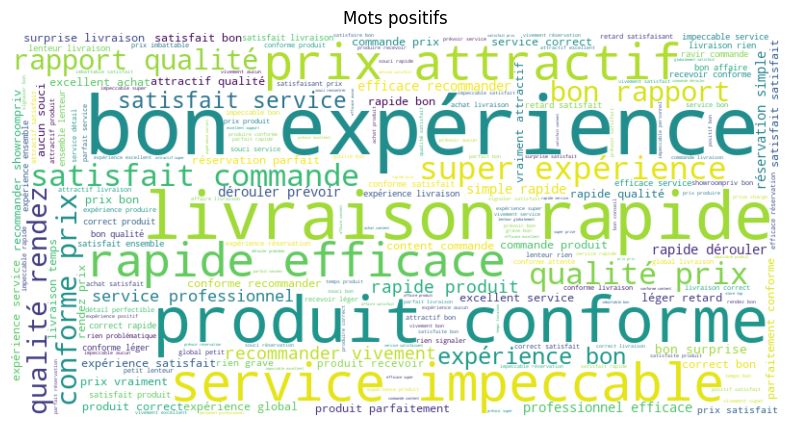

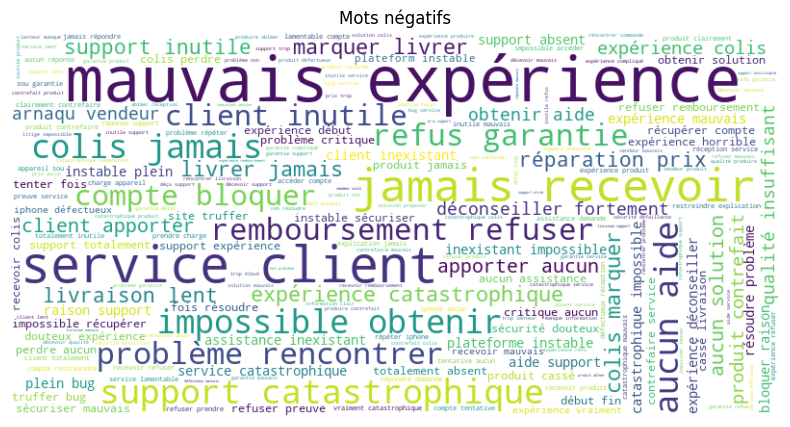

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wc(text, title):
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wc(" ".join(df[df["sentiment"]=="positif"]["text_cleaned"]), "Mots positifs")
plot_wc(" ".join(df[df["sentiment"]=="negatif"]["text_cleaned"]), "Mots négatifs")


In [2]:
import pandas as pd

cleaned_path = "/app/ml/data/cleaned/reviews_cleaned.jsonl"

df = pd.read_json(cleaned_path, lines=True)

print("Dataset chargé :", cleaned_path)
df.head()


Dataset chargé : /app/ml/data/cleaned/reviews_cleaned.jsonl


,text_cleaned,sentiment
0,excellent achat livraison rapide,positif
1,pouvoir mieux faire expérience moyen,neutral
2,support inutilisable mauvais expérience,negatif
3,bon rapport qualité prix satisfait commande pr...,positif
4,litige impossible produit jamais recevoir,negatif


In [3]:
print("Taille :", df.shape)
print(df["sentiment"].value_counts())


Taille : (60440, 2)
sentiment
negatif    32762
positif    22152
neutral     5526
Name: count, dtype: int64


In [4]:
dataset = df[["text_cleaned", "sentiment"]].copy()
dataset.head()


,text_cleaned,sentiment
0,excellent achat livraison rapide,positif
1,pouvoir mieux faire expérience moyen,neutral
2,support inutilisable mauvais expérience,negatif
3,bon rapport qualité prix satisfait commande pr...,positif
4,litige impossible produit jamais recevoir,negatif


In [6]:
X = dataset["text_cleaned"]
y = dataset["sentiment"]


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=25
)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score
import joblib


In [11]:
models = {
    "logreg": LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ),
    "linear_svc": LinearSVC(
        class_weight="balanced"
    ),
    "naive_bayes": MultinomialNB()
}


In [12]:
results = []
trained_pipelines = {}

for name, clf in models.items():
    print(f"\n=== Entraînement du modèle : {name} ===")

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=5000,
            ngram_range=(1, 2),
            strip_accents="unicode"
        )),
        ("clf", clf)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    f1 = f1_score(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)

    print("\nClassification report :")
    print(classification_report(y_test, y_pred))
    print(f"F1 macro = {f1:.3f} | Accuracy = {acc:.3f}")

    results.append({"name": name, "f1_macro": f1, "accuracy": acc})
    trained_pipelines[name] = pipe



=== Entraînement du modèle : logreg ===

Classification report :
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00      6553
     neutral       1.00      1.00      1.00      1105
     positif       1.00      1.00      1.00      4430

    accuracy                           1.00     12088
   macro avg       1.00      1.00      1.00     12088
weighted avg       1.00      1.00      1.00     12088

F1 macro = 0.998 | Accuracy = 0.999

=== Entraînement du modèle : linear_svc ===

Classification report :
              precision    recall  f1-score   support

     negatif       1.00      1.00      1.00      6553
     neutral       1.00      1.00      1.00      1105
     positif       1.00      1.00      1.00      4430

    accuracy                           1.00     12088
   macro avg       1.00      1.00      1.00     12088
weighted avg       1.00      1.00      1.00     12088

F1 macro = 0.999 | Accuracy = 0.999

=== Entraînement du modèle : 

In [30]:
# Trouver le modèle avec le meilleur F1 macro
best = max(results, key=lambda r: r["f1_macro"])
best_name = best["name"]
best_model = trained_pipelines[best_name]

print("\n=== Meilleur modèle ===")
print(f"Modèle : {best_name}")
print(f"F1 macro : {best['f1_macro']:.3f}")
print(f"Accuracy : {best['accuracy']:.3f}")



=== Meilleur modèle ===
Modèle : linear_svc
F1 macro : 0.999
Accuracy : 0.999


In [31]:
best_path = f"/app/ml/models/sentiment_best_{best_name}.pkl"

joblib.dump(best_model, best_path)
print("Modèle sauvegardé sous :", best_path)

Modèle sauvegardé sous : /app/ml/models/sentiment_best_linear_svc.pkl


In [5]:
import os
print(os.listdir("/app/ml"))


['models', 'data', 'notebooks', 'scripts']


In [2]:
import sys
sys.path.append("/app")     # racine du package ml
sys.path.append("/app/ml")  # optionnel


In [3]:
from ml.scripts.model_loader import load_model
from ml.scripts.inference import predict_sentiment

model = load_model()

sentiment, cleaned = predict_sentiment(
    model,
    text="Service Amazon rapide",
    company_name="Amazon"
)

print("Sentiment:", sentiment)
print("Cleaned:", cleaned)

Sentiment: positif
Cleaned: service rapide
